In [1]:
import numpy as np
import pandas as pd
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.feature_extraction import DictVectorizer
import psycopg2 as py
import nltk
import phonetics as ph
from sklearn.metrics import classification_report,roc_auc_score,roc_curve
import pyphen
import syllables
import re
from sklearn.utils import resample
import seaborn as sn
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
%matplotlib inline


In [2]:
con=py.connect(host='192.168.202.21',port='5432',dbname='accrualdb',user='gunjans',password='OX463N@123')

In [3]:
cur=con.cursor()

In [4]:
cur.execute("select LOWER(firstname) firstname,gender,count(1) cnt\
  from  aimm.memberprofile \
  where bank='SBI' \
  and gender  in ('MALE','FEMALE')\
  and COALESCE(firstname,'')!='' group by LOWER(firstname) ,gender")

In [5]:
name_df=pd.DataFrame(cur.fetchall(),columns=['firstname','gender','cnt'])

#  clean firstname and analyse letter distribution

In [6]:
name_df.head()

,firstname,gender,cnt
0,cust-f-name-25072015020259,MALE,1
1,pawra,FEMALE,29
2,khelanpuri,MALE,1
3,leela bai wo bane singh,FEMALE,1
4,bhagyashree gonal,MALE,1


In [7]:
def cleanfirstname(name):
    #remove names starting with 'cust', cust-019292020 etc
    #try:
        if len(name)<3 or name[:4]=='cust':
            name='noname'
        
        #split the name , sometime firstname column also has surname
        name=name.split()[0]

        #remove occurences xxxxx,zzzzz,---,.....,@@ etc
        name=''.join(re.findall('[x|z|-]*([a-zA-Z]+?)[z|x|-]*',name))

        if not name.isalpha():
            name='noname'

        if len(name)<3:
            name='noname'
    #except:
    #    print(name)
    
        return name

In [8]:
#ignore name with len less than 3 and starting with keyword 'cust'

name_df['cleansed_firstname']=name_df.firstname.apply(cleanfirstname)

In [9]:
#Overall population and name, gender combination count
print (name_df.cnt.sum(), name_df.shape)

514771852 (33322890, 4)


In [10]:
#Overall population and firstname first letter, gender combination count and distribution
name_df['firstletter_original']=name_df.firstname.apply(lambda x:x[0] if len(x)>0 else '')
name_df.pivot_table(index=['firstletter_original'],columns=['gender'],values='cnt',aggfunc=['sum','count'])

sum              count         
gender                  FEMALE      MALE   FEMALE     MALE
firstletter_original                                      
                           216       665      207      622
&                          446       920      188      545
(                        17321     11928    10255     8578
)                           41        56       22       23
-                         3067      3294      299      547
.                       451342    458880     2718     3505
/                          123       167       51       67
0                          655      1695      351      840
1                         5378     12571     4832    10464
2                         1057      2867      714     1970
3                          291      1152      245     1032
4                          157       861      133      805
5                          123       726       96      679
6                           96       594       90      563
7                           88      1036       76      990
8                          102      1563      101     1414
9                           92       638       76      604
a                     16124434  27784852   930934  1423648
b                     10386587  18887535   637678  1088211
c                      4960257  22691206   340798  4653562
d                      6611431  14392797   463646   839052
e                       783126   1042026   101232   157222
f                      1632656   1182799   129193   130131
g                      7401462  11568164   437852   732037
h                      3575851   7249237   271268   487093
i                      1607274   2392805   124357   187808
j                      7639783  10945933   473405   667873
k                     16047604  17485960   918343  1203784
l                      6237314   4934865   317232   347306
m                     20364821  29810032  1119495  1989960
n                      9875684  12508092   572929   754650
o                       365152   1214629    36605    77230
p                     15976427  18358599   778041  1094275
q                        28492     37444     6455     9127
r                     19136239  30599200   784716  1232518
s                     43501671  49606582  2151993  2783837
t                      4376615   5789441   367233   505510
u                      2778564   2749228   124677   158443
v                      6273358  12363139   418524   755834
w                       114474    331284    29036    55572
x                         4006     27006      872     4015
y                      1164919   2175504   113159   186901
z                       354737    340347    45225    48691

In [11]:

#Overall population and firstname last letter, gender combination count and distribution
name_df['lastletter_original']=name_df.firstname.apply(lambda x:x[-1] if len(x)>0 else '')
name_df.pivot_table(index=['lastletter_original'],columns=['gender'],values='cnt',aggfunc=['sum','count'])

sum              count         
gender                 FEMALE      MALE   FEMALE     MALE
lastletter_original                                      
                         6995      8338     6295     7357
&                       32653     56867    27574    49267
(                         638      1136      619      990
)                      293288    283275   205600   216452
-                        7844     11721     4145     6944
.                      737452   1195291    87609   161367
/                        2882      4839     2623     4229
0                        5300   1655756     3950   420694
1                        5306   1599915     4650   416734
2                        3966   1605575     3562   416329
3                        3025   1611501     2855   415856
4                        2573   1618187     2464   415913
5                        2880   1625671     2341   416351
6                        2446   1620919     2312   415317
7                        2314   1627270     2228   415596
8                        2379   1634641     2314   416319
9                        2441   1642640     2319   417177
a                    92163318  40211764  2782998  2748493
b                      453398   2667091    70177   181839
c                      154522    347764    35125    86708
d                      895919  13060503   220486   700038
e                     2532145   2971210   361080   421691
f                      118391    852895    71196   119086
g                      748842   1784773   318461   394901
h                     3112421  33974242   513285  1300981
i                    58008027  25300605  2545567  2303965
j                     1308725   6411805    85260   203726
k                     1195632   7365284   128434   296664
l                     4541709  20382177   467376   955523
m                     6055643  16165776   537206   825372
n                    12073766  32132960   927013  1658000
o                     1950251   4020249   267803   578549
p                      914483   5118594    96285   178551
q                       19315    225605    11289    34492
r                     4005229  31412159   658115  1526105
s                     1658565   4606726   217642   499525
t                     2837661  12030079   206478   397090
u                     7982430  13692781   380481   716899
v                      511095   4092503    93216   204987
w                       27477    156044     9431    21177
x                        8467     50761     2457     8878
y                     3189422   9577982   321871   587469
z                      222298    552445    23160    43937

In [12]:
#Overall population and cleansed name, gender combination count
print (name_df[name_df['cleansed_firstname']!='noname'].cnt.sum(), name_df[name_df['cleansed_firstname']!='noname'].shape)

484349431 (27686874, 6)


In [13]:
#Overall population and cleansed name first letter, gender combination count and distribution

name_df['firstletter_cleansed']=name_df.cleansed_firstname.apply(lambda x:x[0] if len(x)>0 else '')
name_df[name_df['cleansed_firstname']!='noname'].pivot_table(index=['firstletter_cleansed'],columns=['gender'],values='cnt',aggfunc=['sum','count'])

sum              count         
gender                  FEMALE      MALE   FEMALE     MALE
firstletter_cleansed                                      
a                     16119244  27623684   930810  1400466
b                     10164269  18522375   613273  1041049
c                      4813387   6259588   323664   516707
d                      6486128  14154575   442416   787710
e                       806129    973381   103402   139539
f                      1627716   1162592   128191   123607
g                      7212327  11248681   419536   691960
h                      3519376   7105388   259270   450304
i                      1612972   2405083   125954   188100
j                      7568911  10820104   464442   650068
k                     15371331  16778258   850796  1124771
l                      6195849   4856986   309764   331377
m                     19866972  26338941  1067842  1703128
n                      9738533  12248094   555895   717581
o                       341320    710761    36546    65553
p                     15696626  17883488   753588  1042070
q                        28364     36832     6422     8904
r                     18953633  30267198   768236  1198060
s                     43114204  48514643  2104480  2657326
t                      4238458   5547577   351004   471503
u                      2809312   2762037   128519   158299
v                      6110855  12056115   401118   711739
w                       107983    322286    26432    52338
x                           14        23       14       23
y                      1130425   2116227   107466   175440
z                           55       121       55      117

In [14]:
#Overall population and cleansed name last letter, gender combination count and distribution

name_df['lastletter_cleansed']=name_df.cleansed_firstname.apply(lambda x:x[-1] if len(x)>0 else '')
name_df[name_df['cleansed_firstname']!='noname'].pivot_table(index=['lastletter_cleansed'],columns=['gender'],values='cnt',aggfunc=['sum','count'])

sum              count         
gender                 FEMALE      MALE   FEMALE     MALE
lastletter_cleansed                                      
a                    96692532  43806964  4264492  3192200
b                      245106   2363592    29699   146535
c                       26672    115707    15889    51857
d                      632260  11753571    97952   773258
e                     2414375   3048098   352397   413612
f                       42562    682438    12162    59778
g                      234566   1282570    64257   178295
h                     2646787  34062395   240354  1388199
i                    56109322  25602827  2919541  2096605
j                     1280793   6747265    56905   250713
k                      781207   6890486    76748   312241
l                     4396137  20395466   320992   960982
m                     5388304  15501887   410157   881727
n                    11816590  32277807   808910  1649531
o                     1682590   2516672   128882   272395
p                      627263   5044528    42383   178655
q                        6981    185685     2590    18703
r                     3195689  24874617   354085  1345094
s                     1070096   3790336    99705   298259
t                     2878575  12633355   215865   515041
u                     8088219  13812812   436625   749596
v                      267890   3979963    33512   182594
w                       19553    150810     5805    18308
x                          61       262       54      204
y                     3090235   9194846   289146   473284
z                          28        79       28       73

In [15]:
#letter wise distribution

In [16]:
import nltk
import matplotlib.pyplot as plt

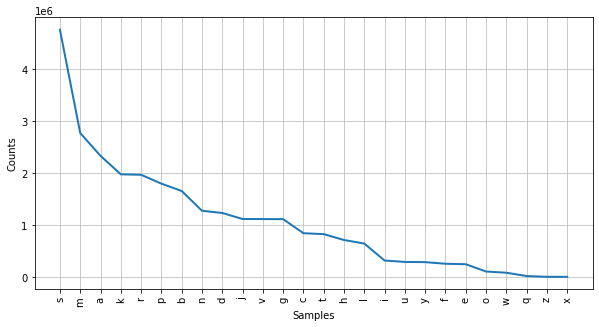

In [17]:
#First letter distribution

dist=nltk.FreqDist([w[:1] for w in name_df[name_df['cleansed_firstname']!='noname']['cleansed_firstname']])
plt.figure(figsize=(10,5))
dist.plot()


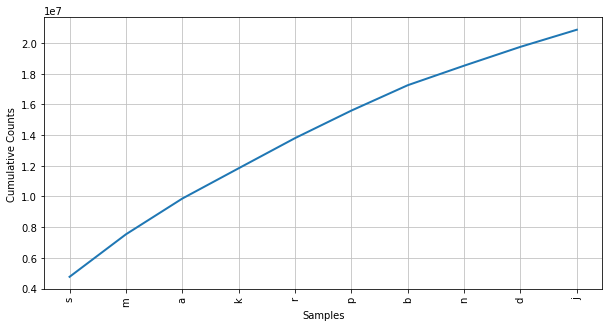

In [18]:
#Top 10 first letters

plt.figure(figsize=(10,5))
dist.plot(10,cumulative=True)

Insights:

Most frequent starting letter in names are s,m,a,k,r,p,b,n,d,v

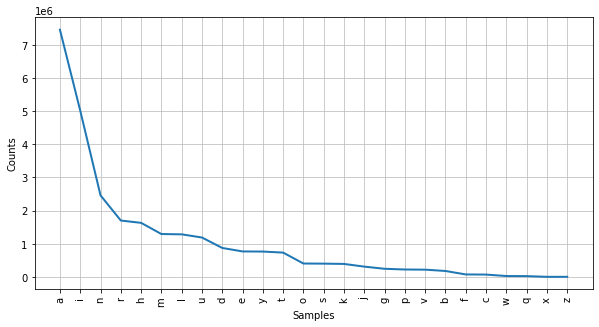

In [19]:
#last letter distribution

dist=nltk.FreqDist([w[-1] for w in name_df[name_df['cleansed_firstname']!='noname']['cleansed_firstname']])
plt.figure(figsize=(10,5))
dist.plot()


# letter and gender wise distribution

In [20]:
#name_df[name_df['cleansed_firstname']!='noname'].pivot_table(index=['firstletter'],columns=['gender'],values='cnt',aggfunc='sum')

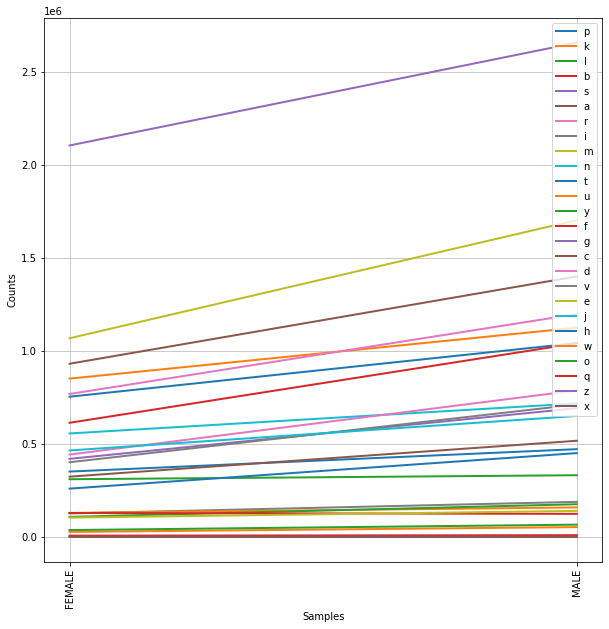

In [21]:
#first letter and gender distribution

dist=nltk.ConditionalFreqDist([(name[:1],gender) for name,gender in zip(name_df[name_df['cleansed_firstname']!='noname']['cleansed_firstname'],name_df[name_df['cleansed_firstname']!='noname']['gender'])])
plt.figure(figsize=(10,10))
dist.plot()


In [22]:
dist.tabulate()

   FEMALE    MALE 
a  930810 1400466 
b  613273 1041049 
c  323664  516707 
d  442416  787710 
e  103402  139539 
f  128191  123607 
g  419536  691960 
h  259270  450304 
i  125954  188100 
j  464442  650068 
k  850796 1124771 
l  309764  331377 
m 1067842 1703128 
n  555895  717581 
o   36546   65553 
p  753588 1042070 
q    6422    8904 
r  768236 1198060 
s 2104480 2657326 
t  351004  471503 
u  128519  158299 
v  401118  711739 
w   26432   52338 
x      14      23 
y  107466  175440 
z      55     117 


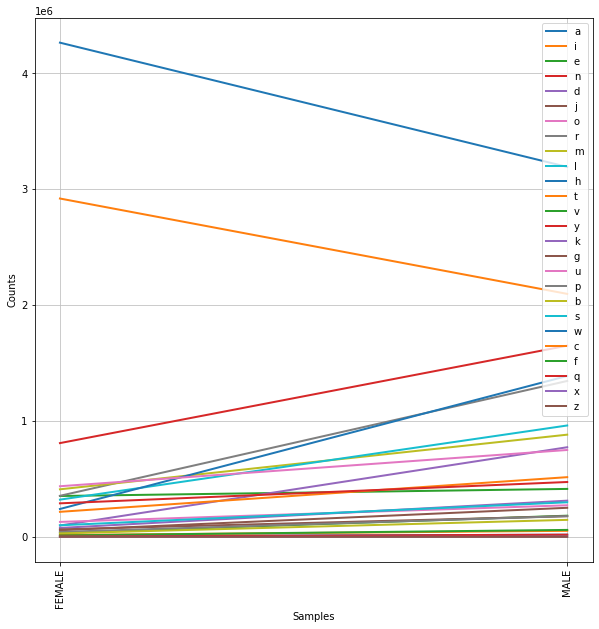

In [23]:
#last letter and gender distribution

dist=nltk.ConditionalFreqDist([(name[-1],gender) for name,gender in zip(name_df[name_df['cleansed_firstname']!='noname']['cleansed_firstname'],name_df[name_df['cleansed_firstname']!='noname']['gender'])])
plt.figure(figsize=(10,10))
dist.plot()


In [24]:
dist.tabulate()

   FEMALE    MALE 
a 4264492 3192200 
b   29699  146535 
c   15889   51857 
d   97952  773258 
e  352397  413612 
f   12162   59778 
g   64257  178295 
h  240354 1388199 
i 2919541 2096605 
j   56905  250713 
k   76748  312241 
l  320992  960982 
m  410157  881727 
n  808910 1649531 
o  128882  272395 
p   42383  178655 
q    2590   18703 
r  354085 1345094 
s   99705  298259 
t  215865  515041 
u  436625  749596 
v   33512  182594 
w    5805   18308 
x      54     204 
y  289146  473284 
z      28      73 


# Select top 2000 first names for each letter

In [25]:
firstletter_name_df=name_df[(name_df['cleansed_firstname']!='noname')].groupby(['firstletter_cleansed','cleansed_firstname']).cnt.agg([('cnt','sum')]).reset_index()

#for each starting letter identify top 2000 names

firstletter_name_top_2000_df=firstletter_name_df.groupby('firstletter_cleansed').apply(lambda x:x.sort_values(by='cnt',ascending=False).head(2000))

firstletter_name_top_2000_df.rename(columns={'firstletter_cleansed':'firstletter_2'},inplace=True)
firstletter_name_top_2000_df.reset_index(inplace=True)
firstletter_name_top_2000_df.drop(columns=['firstletter_2','level_1'],inplace=True)

#For each letter, Top 2000 names populations firstname first letter, gender combination count and distribution

#firstletter_name_top_2000_df.pivot_table(index=['firstletter_cleansed'],values='cnt',aggfunc=['sum','count'])


# Prepare data for training

In [26]:
#select top 2000 first names of each letters

model_data=name_df.merge(firstletter_name_top_2000_df,on=['firstletter_cleansed','cleansed_firstname'],how='inner')
print("Total Population: {} , Cleasned firstname population: {}, Top 2000 firstname population: {}".format(name_df.cnt.sum(),firstletter_name_df.cnt.sum(),model_data.cnt_x.sum()))

#unique firstname, gender combination
training_data=model_data.groupby(['cleansed_firstname','gender']).cnt_x.sum().reset_index()

#for each name, select top gender
training_data= training_data.groupby('cleansed_firstname').apply(lambda x:x.sort_values(by='cnt_x',ascending=False).head(1))

training_data.rename(columns={'cleansed_firstname':'cleansed_firstname_2'},inplace=True)
training_data.reset_index(inplace=True)
training_data.drop(columns=['cleansed_firstname_2','level_1'],inplace=True)

#Overall population and cleansed name first letter, gender combination count and distribution

#training_data['firstletter_cleansed']=training_data.cleansed_firstname.apply(lambda x:x[0] if len(x)>0 else '')
#training_data.pivot_table(index=['firstletter_cleansed'],columns=['gender'],values='cnt_x',aggfunc=['sum','count'])


Total Population: 514771852 , Cleasned firstname population: 484349431, Top 2000 firstname population: 406114992


In [27]:
#Think about feature, whether they are important
#First letter
#first2 letter
#first3 letter
#last letter
#last2 letter
#last3 letter
#starting with vowel
#ending with vowel
#no of syllable

In [28]:
training_data['firstletter']=training_data.cleansed_firstname.apply(lambda x:x[0])
training_data['first2letter']=training_data.cleansed_firstname.apply(lambda x:x[:2])
training_data['first3letter']=training_data.cleansed_firstname.apply(lambda x:x[:3])
training_data['lastletter']=training_data.cleansed_firstname.apply(lambda x:x[-1])
training_data['last2letter']=training_data.cleansed_firstname.apply(lambda x:x[-2:])
training_data['last3letter']=training_data.cleansed_firstname.apply(lambda x:x[-3:])
training_data['startswithvowel']=training_data.cleansed_firstname.apply(lambda x:1 if x[0] in 'aeiou' else 0)
training_data['endwithvowel']=training_data.cleansed_firstname.apply(lambda x:1 if x[-1] in 'aeiou' else 0)
training_data['noofsyllable']=training_data.cleansed_firstname.apply(lambda x:syllables.estimate(x))
training_data['metaphone']=training_data.cleansed_firstname.apply(lambda x:ph.metaphone(x))
training_data['namelength']=training_data.cleansed_firstname.apply(lambda x:len(x))

# analyse categorical variable

In [37]:
#metaphone wise analysis
pd.pivot_table(index='metaphone',columns=['gender'],values='cnt_x',data=training_data.groupby(['metaphone','gender']).cnt_x.sum().reset_index()).to_csv('metaphone.CSV')

#first and last letter analysis
pd.pivot_table(index='firstletter',columns=['lastletter','gender'],values='cnt_x',data=training_data.groupby(['firstletter','lastletter','gender']).cnt_x.sum().reset_index()).to_csv('firstlastletter.CSV')

#first 2 letter analysis
pd.pivot_table(index='first2letter',columns=['gender'],values='cnt_x',data=training_data.groupby(['first2letter','gender']).cnt_x.sum().reset_index()).to_csv('first2letter.CSV')
#last 2 letter analysis
pd.pivot_table(index='last2letter',columns=['gender'],values='cnt_x',data=training_data.groupby(['last2letter','gender']).cnt_x.sum().reset_index()).to_csv('last2letter.CSV')
#first 2 and last 2 letter analysis
pd.pivot_table(index='first2letter',columns=['last2letter','gender'],values='cnt_x',data=training_data.groupby(['first2letter','last2letter','gender']).cnt_x.sum().reset_index()).to_csv('first2last2letter.CSV')

#first 3 letter analysis
pd.pivot_table(index='first3letter',columns=['gender'],values='cnt_x',data=training_data.groupby(['first3letter','gender']).cnt_x.sum().reset_index()).to_csv('first3letter.CSV')
pd.pivot_table(index='last3letter',columns=['gender'],values='cnt_x',data=training_data.groupby(['last3letter','gender']).cnt_x.sum().reset_index()).to_csv('last3letter.CSV')

# analyse numerical variable

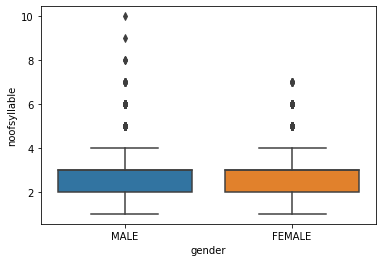

In [40]:
sn.boxplot(x='gender',y='noofsyllable',data=training_data)

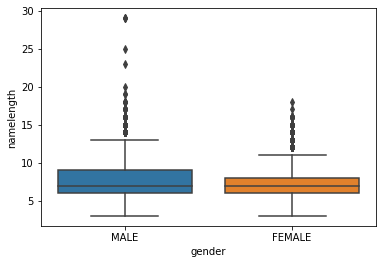

In [41]:
sn.boxplot(x='gender',y='namelength',data=training_data)

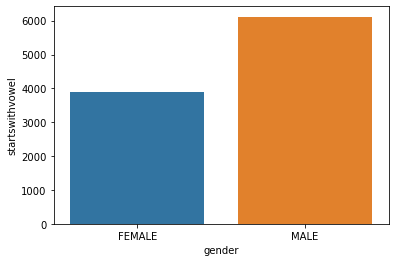

In [42]:
sn.barplot(x='gender',y='startswithvowel',data=training_data.groupby('gender').startswithvowel.sum().reset_index())

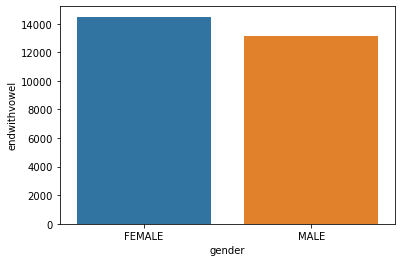

In [43]:
sn.barplot(x='gender',y='endwithvowel',data=training_data.groupby('gender').endwithvowel.sum().reset_index())

In [29]:
def features(name):
    return ({
        'first-letter':name[0],
        'first-2letter':name[:2],
        'first-3letter':name[:3],
        'last-letter':name[-1],
        'last-2letter':name[-2:],
        'last-3letter':name[-3:],
        'namelength':len(name),
        'startswithvowel':1 if name[0] in 'aeiou' else 0,
        'endwithvowel':1 if name[-1] in 'aeiou' else 0,
        'noofsyllable':syllables.estimate(name),
        #'soundex':ph.soundex(name)
        'metaphone':ph.metaphone(name)
        #'nys':ph.nysiis(name)
        #'count':cnt
    })

In [30]:
def getRoccurve(y_test,y_pred_proba):
    fpr,tpr,threshold=roc_curve(y_test,y_pred_proba)
    score=roc_auc_score(y_test,y_pred_proba)
    plt.xlabel('fpr')
    plt.ylabel('tpr')
    plt.plot(fpr,tpr,label='ROC Score %0.2f' %score)
    plt.legend(loc='lower right')
    
    plt.show()

In [31]:
features=np.vectorize(features)

In [33]:
le=LabelEncoder()
training_data['gender']=le.fit_transform(training_data['gender'])

gender_0_oversample=resample(training_data[training_data['gender']==1],n_samples=30000)
gender_1_oversample=resample(training_data[training_data['gender']==0],n_samples=30000)
training_data=pd.concat([gender_0_oversample,gender_1_oversample])

X=features(training_data['cleansed_firstname'])
Y=training_data['gender']
x_train,x_test,y_train,y_test=train_test_split(X,Y,test_size=0.3,random_state=42)


dv=DictVectorizer()
dv.fit(X)


DictVectorizer()

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


              precision    recall  f1-score   support

           0       0.86      0.87      0.86      9056
           1       0.87      0.85      0.86      8944

    accuracy                           0.86     18000
   macro avg       0.86      0.86      0.86     18000
weighted avg       0.86      0.86      0.86     18000



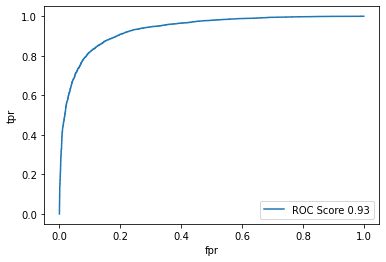

In [66]:
from sklearn.linear_model import LogisticRegression
lr=LogisticRegression()
lr.fit(dv.transform(x_train),y_train)
y_pred=lr.predict(dv.transform(x_test))
y_pred_prob=lr.predict_proba(dv.transform(x_test))
    
print(classification_report(y_test,y_pred))
getRoccurve(y_test,y_pred_prob[:,1])

              precision    recall  f1-score   support

           0       0.93      0.95      0.94      9056
           1       0.95      0.93      0.94      8944

    accuracy                           0.94     18000
   macro avg       0.94      0.94      0.94     18000
weighted avg       0.94      0.94      0.94     18000



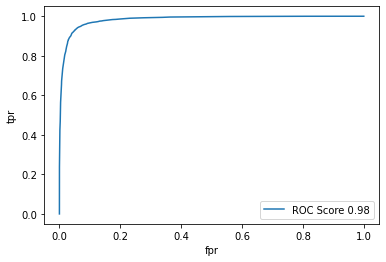

In [67]:
from sklearn.ensemble import RandomForestClassifier
rf=RandomForestClassifier(n_estimators=100)
rf.fit(dv.transform(x_train),y_train)
y_pred=rf.predict(dv.transform(x_test))
y_pred_prob=rf.predict_proba(dv.transform(x_test))
    
print(classification_report(y_test,y_pred))
getRoccurve(y_test,y_pred_prob[:,1])

In [68]:
#feature importance
pd.DataFrame({'columns':dv.feature_names_,'score':rf.feature_importances_}).to_csv('feature_importance.csv')

[16:19:04] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { nround } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


              precision    recall  f1-score   support

           0       0.83      0.85      0.84      9056
           1       0.84      0.82      0.83      8944

    accuracy                           0.83     18000
   macro avg       0.84      0.83      0.83     18000
weighted avg       0.83      0.83      0.83     18000



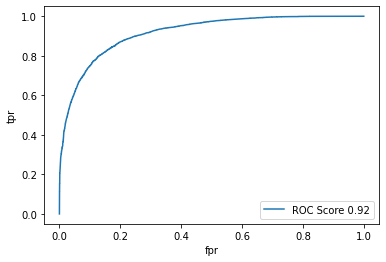

In [69]:
from xgboost import XGBClassifier
xgc=XGBClassifier(nround=20,alpha=0.1,max_depth=8)
xgc.fit(dv.transform(x_train),y_train)
y_pred=xgc.predict(dv.transform(x_test))
y_pred_prob=xgc.predict_proba(dv.transform(x_test))
    
print(classification_report(y_test,y_pred))
getRoccurve(y_test,y_pred_prob[:,1])

In [632]:
from sklearn.model_selection import GridSearchCV

In [633]:
parameter={'aplha':[0.01,0.02,0.03], 'max_depth' :range(6,8),'objective':['binary:logistic']}

In [634]:
xgc=XGBClassifier()

In [635]:
clf=GridSearchCV(xgc,parameter,cv=10)

In [ ]:
clf.fit(dv.transform(x_train),y_train)

In [364]:
confusion_matrix(y_test,y_pred)

array([[4487, 1348],
       [1231, 8340]], dtype=int64)

In [638]:
clf.best_score_

0.8206286326291545

In [640]:
clf.best_params_

{'aplha': 0.01, 'max_depth': 7, 'objective': 'binary:logistic'}

In [245]:
import phonetics as ph

In [250]:
ph.soundex('subhashree')

's0102060'

In [365]:
ph.dmetaphone('subhashree')

('SPXR', '')

In [392]:
ph.nysiis('gunjan')

'GA'

In [415]:
ph.nysiis('sonelal')

'SA'

In [945]:
rf.predict(dv.transform(features(['rose'])))

array([1], dtype=int64)

In [911]:
xgc.predict(dv.transform(features(['priyanshu'])))

array([1], dtype=int64)

In [416]:
dv.transform(features(['gunjan']))

<1x20681 sparse matrix of type '<class 'numpy.float64'>'
	with 7 stored elements in Compressed Sparse Row format>